In [1]:
Project = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Projects/Adipocyte'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import copy

plt.rcParams.update(plt.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

plt.rcParams['ps.useafm']=True
plt.rcParams['pdf.fonttype']=42

plt.rc('font', size=7)          # controls default text sizes
plt.rc('axes', titlesize=7)     # fontsize of the axes title
plt.rc('axes', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
plt.rc('legend', fontsize=6)    # legend fontsize
suptitlesize = 7

plt.rc('axes', axisbelow=True) #push axes to back
mpl.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.facecolor']='#E7E8E9'

In [2]:
MitoCarta3_file = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/MITOCARTA3.0/Mouse.MitoCarta3.0.xls'
MitoCarta = pd.read_excel(MitoCarta3_file, 'A Mouse MitoCarta3.0')
MitoPW = pd.read_excel(MitoCarta3_file, 'C MitoPathways')

name2ID = MitoCarta[['Symbol','EnsemblGeneID']].set_index('Symbol')['EnsemblGeneID'].to_dict()

MitoPW['PW level'] = MitoPW['MitoPathway Hierarchy'].str.split('>').str.len()
MitoPW['gene_ids'] = ''
for i in range(len(MitoPW)):
    for gene in MitoPW.iloc[i,:]['Genes'].split(', '):
        if type(name2ID[gene]) == float : continue
        MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
    MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]
MitoPW = MitoPW.set_index('MitoPathway',drop=True)

mtDNA = MitoCarta[['Symbol','EnsemblGeneID']]
mtDNA = mtDNA[mtDNA['Symbol'].str.startswith('mt-')].reset_index(drop=True)
mtDNA = mtDNA.rename(columns={'Symbol':'gene_name', 'EnsemblGeneID':'gene_id'})[['gene_id']]

/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_32920/466202503.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_32920/466202503.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]


In [3]:
OXPHOS_C = {f'C{n}' : pd.DataFrame({'gene_id' : MitoPW.loc[f'C{n} subunits','gene_ids'].split(',')}) for n in ['I','II','III','IV','V']}
# display(OXPHOS_C)

---

In [4]:
RNA = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RNA_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')

table = {}
table['RNA'] = RNA

display(table['RNA'])

,gene_id,R4,R8
0,ENSMUSG00000033845,1.919982,2.397623
1,ENSMUSG00000025903,0.564052,0.894128
2,ENSMUSG00000033813,-0.823592,0.210519
3,ENSMUSG00000033793,0.192070,-0.043765
4,ENSMUSG00000025907,-0.130110,0.328257
...,...,...,...
12206,ENSMUSG00000064360,1.702209,3.022970
12207,ENSMUSG00000064363,1.677543,2.216408
12208,ENSMUSG00000064367,1.287624,1.643277
12209,ENSMUSG00000064368,1.477040,2.066885


In [5]:
RNA = pd.read_csv(f'{Project}/Results/Other_papers/Reid_etal.2017.Scientific_Reports/Tables/Exp_calc/v20230826/Reid_RNA_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')

table['Reid_RNA'] = RNA

display(table['Reid_RNA'])

,gene_id,R_BD5,R_WD5
0,ENSMUSG00000051951,-2.880399,-1.182950
1,ENSMUSG00000033845,1.867688,1.890634
2,ENSMUSG00000025903,1.189451,0.326595
3,ENSMUSG00000033813,0.036676,-1.075665
4,ENSMUSG00000033793,-0.123633,0.071399
...,...,...,...
12135,ENSMUSG00000065947,3.606454,0.673563
12136,ENSMUSG00000064363,2.520375,1.027431
12137,ENSMUSG00000064367,2.415292,0.981886
12138,ENSMUSG00000064368,3.015609,1.114483


In [6]:
CHIP = pd.read_csv('/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/GSEA/chip/Mouse_Ensembl_Gene_ID_MSigDB.v2022.1.Mm.chip', sep='\t', usecols=['Probe Set ID','Gene Symbol']).rename(columns={'Probe Set ID':'gene_id','Gene Symbol':'gene_name'})

In [7]:
data = pd.merge(table['RNA'], table['Reid_RNA'], on='gene_id', how='outer')
data = pd.merge(CHIP, data, on='gene_id')
mtDNA_data = pd.merge(mtDNA, data, on='gene_id', how='left')

data_dict = {}
for Cn in ['CI','CIII','CIV','CV']:
    data_dict[Cn] = pd.merge(mtDNA_data, OXPHOS_C[Cn], on='gene_id').sort_values('gene_name').reset_index(drop=True)

display(data_dict)

{'CI':               gene_id gene_name        R4        R8     R_BD5     R_WD5
 0  ENSMUSG00000064341    mt-Nd1  2.226110  2.404091  2.571149  1.751519
 1  ENSMUSG00000064345    mt-Nd2  2.430607  2.656217  3.417775  2.119041
 2  ENSMUSG00000064360    mt-Nd3  1.702209  3.022970  3.777718  0.863305
 3  ENSMUSG00000064363    mt-Nd4  1.677543  2.216408  2.520375  1.027431
 4  ENSMUSG00000065947   mt-Nd4l       NaN       NaN  3.606454  0.673563
 5  ENSMUSG00000064367    mt-Nd5  1.287624  1.643277  2.415292  0.981886
 6  ENSMUSG00000064368    mt-Nd6  1.477040  2.066885  3.015609  1.114483,
 'CIII':               gene_id gene_name       R4        R8     R_BD5    R_WD5
 0  ENSMUSG00000064370   mt-Cytb  1.58131  1.420794  2.214727  0.84257,
 'CIV':               gene_id gene_name        R4        R8     R_BD5     R_WD5
 0  ENSMUSG00000064351    mt-Co1  1.458177  2.162202  2.433640  1.482037
 1  ENSMUSG00000064354    mt-Co2  3.052747  3.297602  6.285538  0.623114
 2  ENSMUSG00000064358    mt-Co3

----

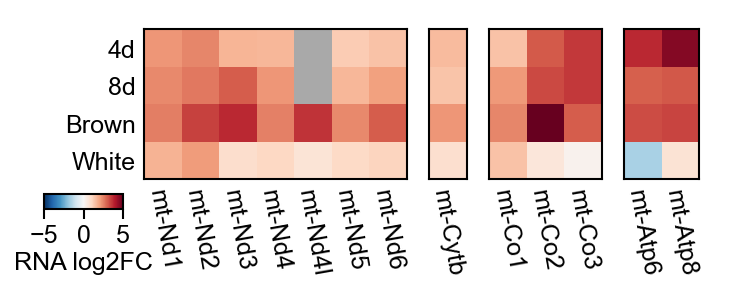

In [8]:
using_cm = copy.copy(mpl.colormaps.get_cmap("RdBu_r"))
using_cm.set_bad('darkgray',1.)

sF = 1 # Size factor
wgap = 0.075
hgap = 0.1
nrow, ncol = 1, len(data_dict)

width_ratios = np.array([len(data_dict[Cn])/4 for Cn in data_dict]) / 2
height_ratios = np.array([1]) / 2

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)

row = 0
col = 0
for Cn in data_dict:
    ax = fig.add_subplot(grid[row,col])

    plot_data = data_dict[Cn].drop(columns='gene_id').set_index('gene_name', drop=True).T
    heat1 = ax.pcolormesh(plot_data[::-1],
                          cmap=using_cm, vmin=-5, vmax=5)

    ax.set_xticks([i+0.5 for i in range(len(plot_data.columns))])
    ax.set_yticks([]) 
    ax.set_xticklabels(plot_data.columns, rotation=-80, ha='center')
    ax.tick_params(length=0, pad=2)
    # ax.tick_params(width=0.5, length=3, pad=1)
    # ax.xaxis.tick_top()

    if col==0:
        ax.set_yticks([i+0.5 for i in range(len(plot_data))][::-1]) 
        ax.set_yticklabels(['4d','8d','Brown','White'])

        cbar = plt.colorbar(heat1, ax=ax, cax = ax.inset_axes([-0.38, -0.2, 0.3, 0.1]), orientation='horizontal')
        cbar.ax.set_xlabel('RNA log2FC', labelpad=1, fontsize=6)
        cbar.ax.set_xticks([-5,0,5])
        cbar.ax.tick_params(width=0.5, length=2.5, pad=1)

    col+=1

plt.savefig('comp_mtDNA_RNAlogFC_heatmap.pdf', bbox_inches='tight')
plt.show()
plt.close()